In [ ]:
! pip install matplotlib numpy pandas tensorflow scikit-learn

In [ ]:
! pip install beautifulsoup4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  import matplotlib.pyplot as plt
  import numpy as np
  import pandas as pd
  import tensorflow as tf

  from sklearn.metrics import accuracy_score, precision_score, recall_score
  from sklearn.model_selection import train_test_split
  from tensorflow.keras import layers, losses, saving
  from tensorflow.keras.datasets import fashion_mnist
  from tensorflow.keras.models import Model, load_model
  from datetime import datetime

In [ ]:
def parse_datetime(date_str):

    try:
        # First, try with milliseconds
        return datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S.%f %Z").timestamp()
    except ValueError:
        # If milliseconds are absent, try without them
        return datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S %Z").timestamp()

In [ ]:

dataframe = pd.read_csv('/content/drive/MyDrive/Marketing Spire Lux Combined Format All Sources.csv', header=None)
# raw_data = dataframe.values

# raw_data = dataframe.iloc[0:-1,[3, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18]]
raw_data = dataframe.iloc[0:-1,[5, 6, 7, 8, 9]]

raw_data.columns = raw_data.iloc[0]
raw_data = raw_data.iloc[1:]

 # raw_data.drop('')

# raw_data = raw_data[raw_data.eta.apply(lambda x: isinstance(x, str))]

raw_data.latitude = pd.to_numeric(raw_data.latitude)
raw_data.longitude = pd.to_numeric(raw_data.longitude)
raw_data.speed = pd.to_numeric(raw_data.speed)
raw_data.course = pd.to_numeric(raw_data.course)
raw_data.heading = pd.to_numeric(raw_data.heading)
# raw_data.draught = pd.to_numeric(raw_data.draught)
# raw_data.length = pd.to_numeric(raw_data.length)
# raw_data.ship_and_cargo_type = pd.to_numeric(raw_data.ship_and_cargo_type)
# raw_data.width = pd.to_numeric(raw_data.width)
# # raw_data
# raw_data.eta = raw_data.eta.apply(parse_datetime)
# raw_data.position_updated_at = raw_data.position_updated_at.apply(parse_datetime)
# raw_data['diff_time'] = raw_data.eta - raw_data.position_updated_at

# raw_data.drop(labels="eta",axis="columns", inplace=True)
# raw_data.drop(labels="position_updated_at",axis="columns", inplace=True)
# raw_data[raw_data.eta.apply(lambda x: isinstance(x, str))]
# raw_data.destination = pd.to_numeric(raw_data.)
raw_data['labels'] = 1

# raw_data = raw_data.values

raw_data.dtypes
# raw_data.iloc[0:25, :]


,0
0,
latitude,float64
longitude,float64
speed,float64
course,float64
heading,int64
labels,int64


In [ ]:
# The last element contains the labels
labels = raw_data.values[:, -1]

# The other data points are the electrocadriogram data
data = raw_data.values[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

# train_data[0]

np.max(train_data[:, 0])
# train_data[8, 0]

22.852561666666663

In [ ]:
min_val = tf.reduce_min(train_data, axis=0)
max_val = tf.reduce_max(train_data, axis=0)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_data[:10, 0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.43864703, 0.55551535, 0.7340612 , 0.4923744 , 0.8547912 ,
       0.5763721 , 0.35937145, 0.13392125, 0.42775196, 0.60173374],
      dtype=float32)>

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[0:-100, :]
normal_test_data = test_data[0:-100, :]

anomalous_train_data = train_data[-99:-1, :]
anomalous_test_data = test_data[-99:-1, :]

normal_train_data[ 0, :]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.43864703, 0.414524  , 0.54545456, 0.11111111, 0.0704501 ],
      dtype=float32)>

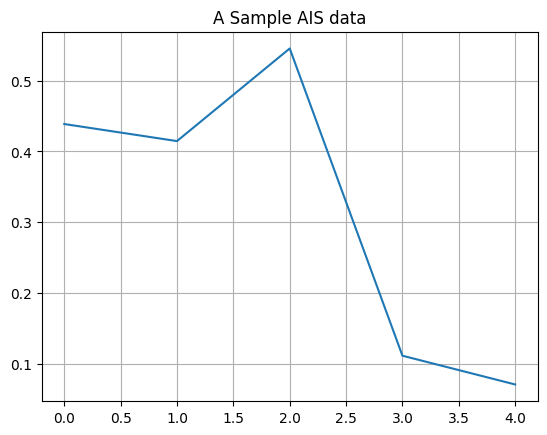

In [ ]:
plt.grid()
plt.plot(np.arange(5), train_data[0])
plt.title("A Sample AIS data")
plt.show()

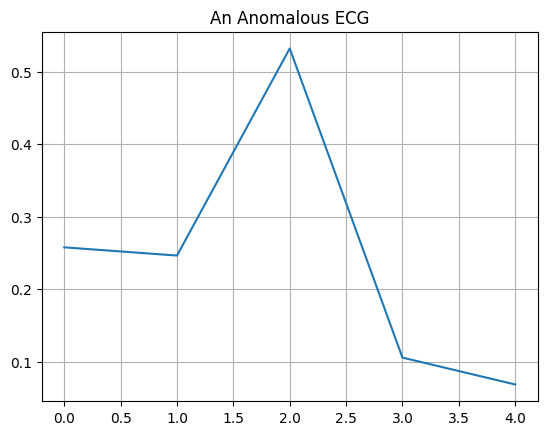

In [ ]:
plt.grid()
plt.plot(np.arange(5), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [ ]:
@saving.register_keras_serializable()
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu"),
      layers.Dense(4, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(5, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 815ms/step - loss: 0.2567 - val_loss: 0.2502
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2492 - val_loss: 0.2428
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2410 - val_loss: 0.2332
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2297 - val_loss: 0.2178
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2117 - val_loss: 0.1989
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1922 - val_loss: 0.1807
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1750 - val_loss: 0.1597
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1553 - val_loss: 0.1443
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1403 - val_loss: 0.1337
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1308 - val_loss: 0.1246
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1216 - val_loss: 0.1166
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1140 - va

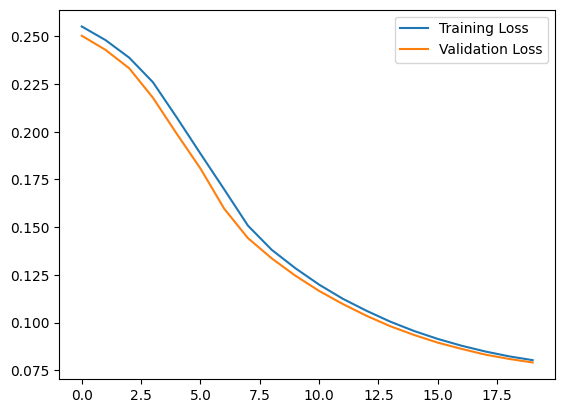

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

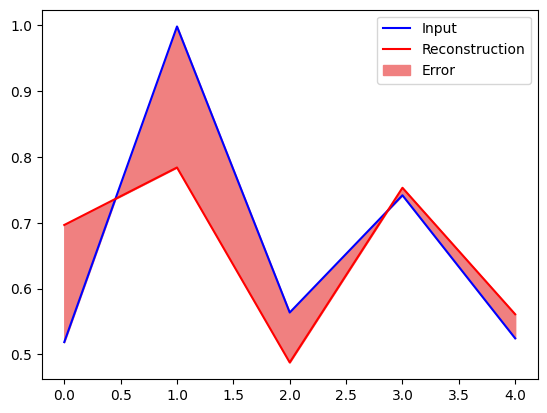

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(5), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

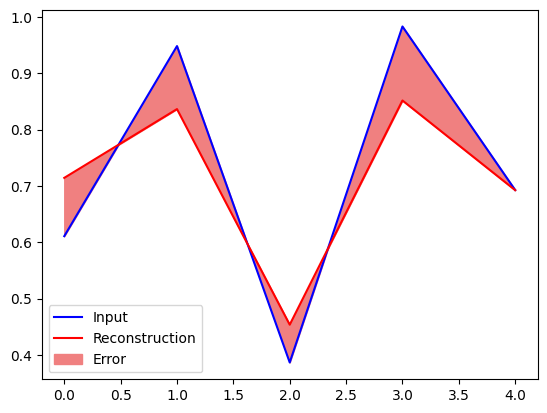

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(5), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


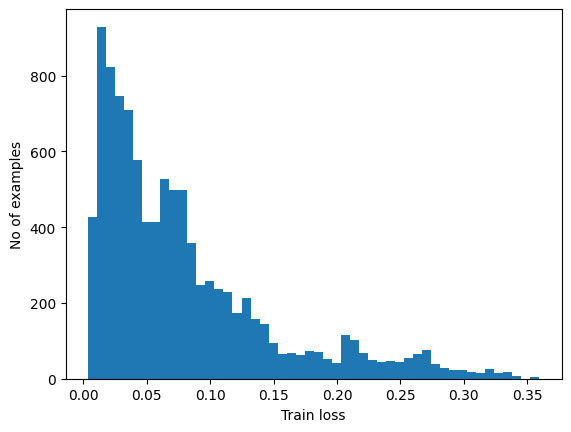

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.14881697


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


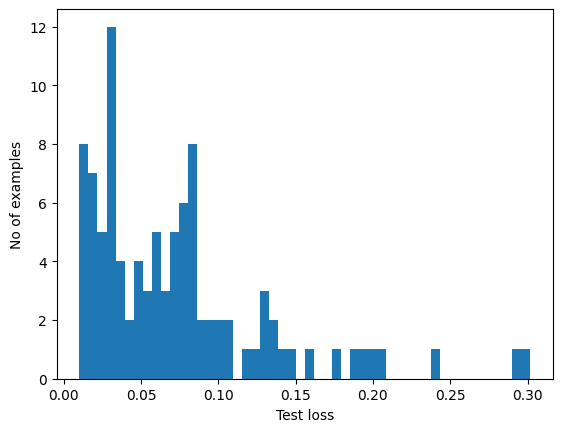

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.8664817749603804
Precision = 1.0
Recall = 0.8664817749603804


In [ ]:
test_data[1000:1001, :]

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.7074571 , 0.5646914 , 0.72727275, 0.10833333, 0.05870841]],
      dtype=float32)>

In [ ]:
def accuracy(data_stream):
  predict_random = autoencoder.predict(data_stream)
  test_loss_random = tf.keras.losses.mae(predict_random, data_stream)
  return test_loss_random[0].numpy()

In [ ]:
accuracy(test_data[1000: 1001])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


0.08668671

In [ ]:
!pip install websockets

import asyncio
import websockets
import json
from datetime import datetime, timezone

In [ ]:
raw_data.dtypes

,0
0,
latitude,float64
longitude,float64
speed,float64
course,float64
heading,int64
labels,int64


In [ ]:
autoencoder.save("model.keras")

In [ ]:
async def connect_ais_stream():

    async with websockets.connect("wss://stream.aisstream.io/v0/stream") as websocket:
        subscribe_message = {"APIKey": "<api_key>",  # Required !
                            #  "BoundingBoxes": [[[23.625663463280404, 66.31232119844522], [15.899274547801024, 74.17853223505227]]], # Required!
                            #  "BoundingBoxes": [[[24.95942098751467, 59.454508068184865], [13.8937972985918, 76.34879308712635]]], # Required!
                            #  "BoundingBoxes": [[[22.71234, 67.81223], [22.71141, 73.83124]], [[16.03114, 67.81142], [22.71123, 73.83123]]], # Required!
                             "BoundingBoxes": [[[28.85898853164005, -96.78569202255129],[24.12156459876252, -82.81108247148403]]], # Required!
                            #  "FiltersShipMMSI": ["368207620", "367719770", "211476060"], # Optional!
                             "FilterMessageTypes": ["PositionReport", "ShipStaticData"] # Optional!
        }

        subscribe_message_json = json.dumps(subscribe_message)
        await websocket.send(subscribe_message_json)

        async for message_json in websocket:
            message = json.loads(message_json)

            message_type = message["MessageType"]

            print(message_type, message['MetaData']['MMSI'])

            if message_type == "PositionReport":
                ais_message = message['Message']['PositionReport']
            #     ais_message_static = message['Message']['ShipStaticData']

            #     print(ais_message_static['Eta'])

                data_arr = np.array([[ais_message['Latitude'],
                                     ais_message['Longitude'],
                                     ais_message['Sog'],
                                     ais_message['Cog'],
                                     ais_message['TrueHeading'],
                                    #  ais_message_static['MaximumStaticDraught'],
                                    #  ais_message_static['Type'],
                                    #  max(ais_message_static['Dimension']['A'], ais_message_static['Dimension']['B']),
                                    #  max(ais_message_static['Dimension']['C'],ais_message_static['Dimension']['D']),
                                    #     ais_message_static['eta']
                                     ]])

                # min_val = tf.reduce_min(data_arr, axis=0)
                # max_val = tf.reduce_max(data_arr, axis=0)

                data_arr = (data_arr - min_val) / (max_val - min_val)

                print(accuracy(data_arr))

                # print(data_arr)

In [ ]:
await connect_ais_stream()

PositionReport 367635140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
108.54317
PositionReport 367102000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
129.52066
PositionReport 367635140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
104.82314
PositionReport 368223280
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
185.94888
PositionReport 367635140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
105.58311
PositionReport 366100000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
113.80144
PositionReport 367102000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
130.08191
PositionReport 367635140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
106.92306
PositionReport 367102000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
129.56223
PositionReport 538005124
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
128.37717
PositionReport 236538000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
71.693504
PositionReport 368223280
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
159.70886
PositionReport 538005124
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
130.91718
PositionReport 367102000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

CancelledError: 

In [ ]:
model = load_model('/content/drive/MyDrive/model (1).keras')

In [ ]:
Latitude, Longitude, Sog, Cog, Heading, Cargo and Vessel Type, Length, Width, Draught, time difference between current time and eta